# 构建GNN

In [1]:
import torch as t
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import torch.nn as nn

# DATA

In [2]:
# (node, label)集
N = [("n{}".format(i), 0) for i in range(1, 7)] + \
    [("n{}".format(i), 1) for i in range(7, 13)] + \
    [("n{}".format(i), 2) for i in range(13, 19)]
# 边集
E = [("n1", "n2"), ("n1", "n3"), ("n1", "n5"),
     ("n2", "n4"),
     ("n3", "n6"), ("n3", "n9"),
     ("n4", "n5"), ("n4", "n6"), ("n4", "n8"),
     ("n5", "n14"),
     ("n7", "n8"), ("n7", "n9"), ("n7", "n11"),
     ("n8", "n10"), ("n8", "n11"), ("n8", "n12"),
     ("n9", "n10"), ("n9", "n14"),
     ("n10", "n12"),
     ("n11", "n18"),
     ("n13", "n15"), ("n13", "n16"), ("n13", "n18"),
     ("n14", "n16"), ("n14", "n18"),
     ("n15", "n16"), ("n15", "n18"),
     ("n17", "n18")]

print(N)
print(E)

[('n1', 0), ('n2', 0), ('n3', 0), ('n4', 0), ('n5', 0), ('n6', 0), ('n7', 1), ('n8', 1), ('n9', 1), ('n10', 1), ('n11', 1), ('n12', 1), ('n13', 2), ('n14', 2), ('n15', 2), ('n16', 2), ('n17', 2), ('n18', 2)]
[('n1', 'n2'), ('n1', 'n3'), ('n1', 'n5'), ('n2', 'n4'), ('n3', 'n6'), ('n3', 'n9'), ('n4', 'n5'), ('n4', 'n6'), ('n4', 'n8'), ('n5', 'n14'), ('n7', 'n8'), ('n7', 'n9'), ('n7', 'n11'), ('n8', 'n10'), ('n8', 'n11'), ('n8', 'n12'), ('n9', 'n10'), ('n9', 'n14'), ('n10', 'n12'), ('n11', 'n18'), ('n13', 'n15'), ('n13', 'n16'), ('n13', 'n18'), ('n14', 'n16'), ('n14', 'n18'), ('n15', 'n16'), ('n15', 'n18'), ('n17', 'n18')]


# 显示出来

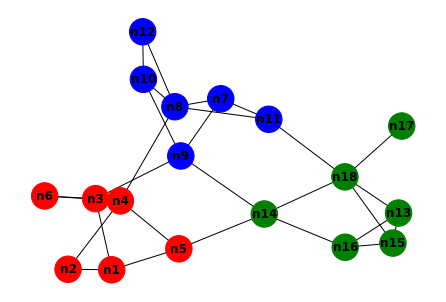

In [8]:
G=nx.Graph()
nodes = list(map(lambda x: x[0], N))
G.add_nodes_from(list(map(lambda x:x[0],N)))
G.add_edges_from(E)
#设置属性
ncolor = ['r'] * 6 + ['b'] * 6 + ['g'] * 6
nsize = [700] * 6 + [700] * 6 + [700] * 6
# 显示Graph
plt.figure(1)
nx.draw(G, with_labels=True, font_weight='bold',
        node_color=ncolor, node_size=nsize)


# 模型构建

In [ ]:
class Xi(nn.module):
    """
    实现Xi函数，输入一个batch的相邻节点特征向量对ln，返回的是s*s的A矩阵
    """
    def __init__(self,ln,s) -> None:
        super().__init__()
        self.ln=ln
        self.s = s
        # linear layer 
        self.linear = nn.Linear(2*self.ln,s*s,bias=True)
        # activation layer
        self.tanh = nn.Tanh()
    
    def forward(self,X:t.Tensor):
        """
        X: (N,2*ln)输入节点特征以及邻居节点特征concat起来
        return : (N,S,S)，输出用于线性变换的参数矩阵
        """
        bs= X.size()[0]
        out = self.linear(X)
        out = self.tanh(out)
        out = out.view(bs,self.s,self.s)
        return out
    
# function Rou
class Rou(nn.Module):
    def __init__(self,ln,s) -> None:
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(ln,s),
            nn.Tanh()
        )
    def forward(self,X:t.Tensor):
        out = self.linear(X)
        return out

class Hw(nn.Module):
    def __init__(self,ln,s,mu=0.9) -> None:
        super().__init__()
        self.ln=ln
        self.s=s
        self.mu =mu
        # init network layers
        self.Xi = Xi(self.ln,self.s)
        self.Rou = Rou(self.ln,self.s)

    def forward(self,X,H,dg_list):
        """
        X (N,2*ln)一个节点特征向量和该节点的某一个邻接向量concatenate得到的向量
        H (N,s)对应中心节点的状态向量
        dg_list : (N,) 对应中心节点的度的向量
        return :(N,s)
        """
        if type(dg_list)==list:
            dg_list = t.tensor(dg_list)
        elif isinstance(dg_list,t.Tensor):
            pass
        else:
            raise TypeError(
                "==> dg_list should be list or tensor, not {}".format(type(dg_list)))
        A= (self.Xi(X)*self.mu/self.s)/dg_list.view(-1,1,1)
        b=self.Rou(t.chunk(X,chunks=2,dim=1)[0])
        # (N, s, s) * (N, s) + (N, s)
        out = t.squeeze(t.matmul(A, t.unsqueeze(H, 2)), -1) + b
        return out    # (N, s)

class AggrSum(nn.Module):
    """
    信息聚合
    """
    def __init__(self,node_num:int) -> None:
        super().__init__()
        self.V= node_num

    def forward(self, H:t.Tensor, X_node: t.Tensor)->t.Tensor:
        # H: (N,s)->(V,s)
        # X_node:(N,)
        mask=t.stack([X_node]*self.V,0)
        mask=mask.float()-t.unsqueeze(t.range(0,self.V-1).float(),1)
        mask = (mask==0).float()
        # (V,N)*(N,s)->(V,s)
        return t.mm(mask,H)

class OriLinearGNN(nn.Module):
    """
    The graph neural network model
    """
    def __init__(self,node_num,feat_dim,stat_dim,T) -> None:
        super().__init__()
        """
        初始化模型函数。
        
        :param node_num: 节点数量
        :param feat_dim: 节点特征维度
        :param stat_dim: 节点状态维度
        :param T       : GNN更新轮数
        """
        self.node_num=node_num
        self.feat_dim= feat_dim
        self.stat_dim=stat_dim
        self.T=T
        # 初始化节点的嵌入向量，也就是hv，(V,ln)
        self.node_features=nn.parameter.Parameter(
            data=t.randn((self.node_num,self.feat_dim),dtype=t.float32),
            requires_grad=True)
        # 输出层g
        self.linear=nn.Linear(feat_dim+stat_dim,3)
        self.softmax = nn.Softmax(0)
        # Fw
        self.Hw=Hw(feat_dim,stat_dim)
        # H的分组求和
        self.Aggr = AggrSum(node_num)
    
    def forward(self,X_Node,X_Neis,dg_list):
        """前向计算函数。值得注意的是，这里输入的X_Node和N_Neis的第一个维度`N`表示边的个数。
        比如：
            X_Node: [0, 0, 0, 1, 1, ..., 18, 18]
            X_Neis: [1, 2, 4, 1, 4, ..., 11, 13]
        :param X_Node: 节点索引
        :param X_Neis: X_node对应节点邻居的索引
        :param dg_list: 节点的度列表
        """
        node_embeds=self.node_features[X_Node]
        neis_embeds=self.node_features[X_Neis]
        X=t.cat((node_embeds,neis_embeds),1)
        # 初始化节点的状态向量
        node_states=t.zeros((self.node_num,self.stat_dim),dtype=t.float32)
        # 循环t次
        for _ in range(self.T):
            # (V,s)->(N,s)
            H=t.index_select(node_states,0,X_Node)
            #(N,s)->(N,s)
            H=self.Hw(X,H,dg_list)
            #(N,s)->(V,s)
            node_states=self.Aggr(H,X_Node)
        out = self.linear(t.cat((self.node_features.data,node_states),1))
        out =self.softmax(out)
        return out # (V,3)
